In [1]:
import pandas as pd
import gmaps as gp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mp
from shapely.geometry import shape, MultiPolygon, Point, LineString
import geojson
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

TAM_IMG=(12,8) #Tamaño de las imagenes
dest_img = "./imagenes/"

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def guardar_imagen(nombre):
    plt.savefig(dest_img + nombre.strip().replace(' ','-') + '.png', transparent=True)

In [3]:
def plotear_distancias(df,x,y,titulo,color_reg='red',color_scatter='blue',label_x=None,label_y=None):
    fig, ax = plt.subplots(figsize=TAM_IMG)
    fit = np.polyfit(df[x],df[y], deg=1)
    ax.plot(df[x], fit[0] * df[x] + fit[1], color=color_reg)
    ax.scatter(df[x], df[y],color=color_scatter)
    plt.title(titulo,size=20)
    if(label_x and label_y):
        plt.xlabel(label_x)
        plt.ylabel(label_y)
    guardar_imagen(titulo)
    plt.show()

In [4]:
#Distancia minima entre un punto y una lista de puntos
from haversine import haversine
def distancia_minima(partida, points):
    dist_min = 9999999
    distancias=[]
    for destino in points:
        dist= round(haversine(partida,destino),1)
        if (dist<dist_min):
            dist_min = dist
    return dist

In [5]:
properati = pd.read_csv('datos/properati_2.csv')

In [6]:
properati.dtypes

created_on                     object
operation                      object
property_type                  object
place_name                     object
place_with_parent_names        object
country_name                   object
state_name                     object
geonames_id                   float64
lat-lon                        object
lat                           float64
lon                           float64
price                         float64
currency                       object
price_aprox_local_currency    float64
price_aprox_usd               float64
surface_total_in_m2           float64
surface_covered_in_m2         float64
price_usd_per_m2              float64
price_per_m2                  float64
floor                         float64
rooms                         float64
expenses                      float64
properati_url                  object
description                    object
title                          object
image_thumbnail                object
dtype: objec

In [7]:
properati.loc[:,('created_on')] = pd.to_datetime(properati['created_on'])

In [8]:
#Saco algunas columnas que no parecen servir
properati_filtrado = properati.drop( ['country_name','geonames_id','place_with_parent_names','operation','image_thumbnail'], 1)
# los geonames hacen referencia a place_name y no a la propiedad
properati_filtrado.dropna(how='all',inplace=True)
properati_filtrado = properati_filtrado.loc[properati_filtrado.price_per_m2 < 100000]
properati_filtrado['lat-lon'] = zip(properati_filtrado['lat-lon'])

## Cantidad de propiedades segun zona

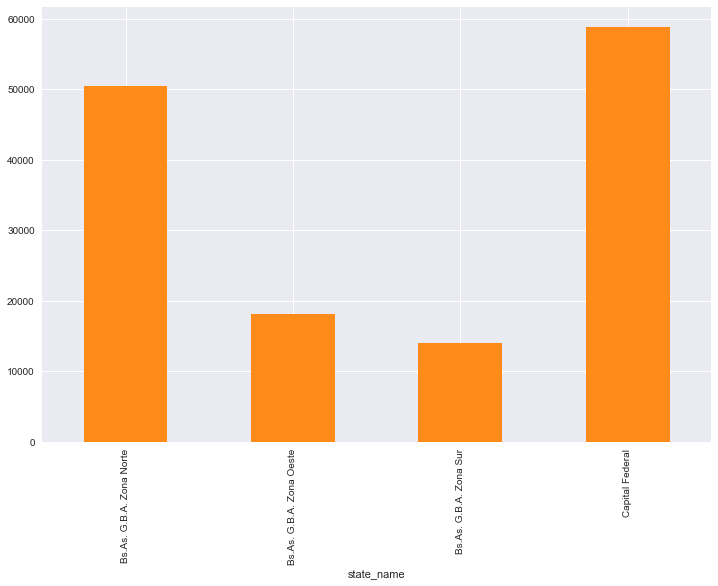

In [9]:
properati_filtrado.groupby('state_name').count()['created_on'].plot(kind='bar',figsize=TAM_IMG,color='#ff8c1a')
titulo = 'Cantidad de propiedades segun zona'
guardar_imagen(titulo)
plt.show()

## Precio por m2 promedio por zona

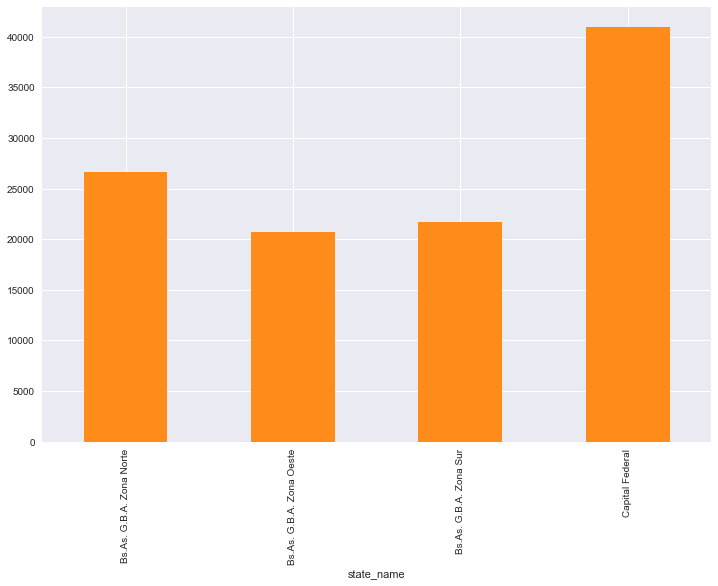

In [10]:
properati_filtrado.groupby('state_name').mean()['price_per_m2'].plot(kind='bar',figsize=TAM_IMG,color='#ff8c1a')
titulo = 'Precio por m2 promedio por zona'
guardar_imagen(titulo)
plt.show()

## Promedio de superficie de propiedades por zona

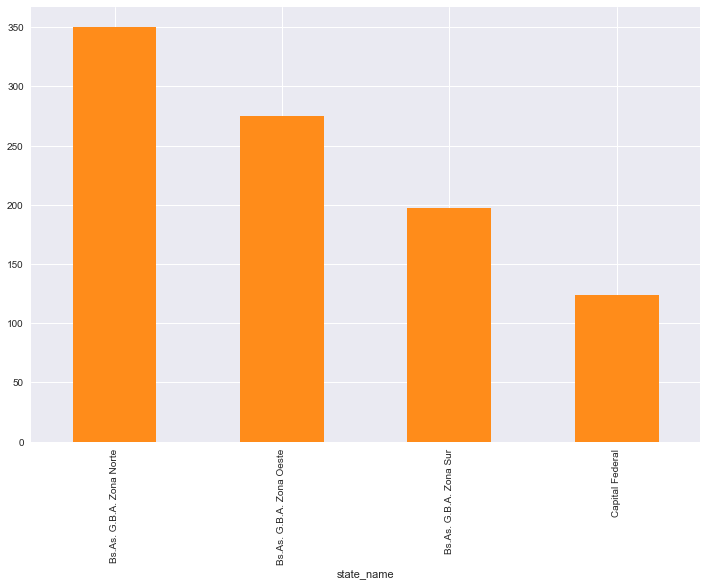

In [11]:
properati_filtrado.groupby('state_name').mean()['surface_total_in_m2'].plot(kind='bar',figsize=TAM_IMG,color='#ff8c1a')
titulo = ' Promedio de superficie de propiedades por zona'
guardar_imagen(titulo)
plt.show()


## Pisos por zona

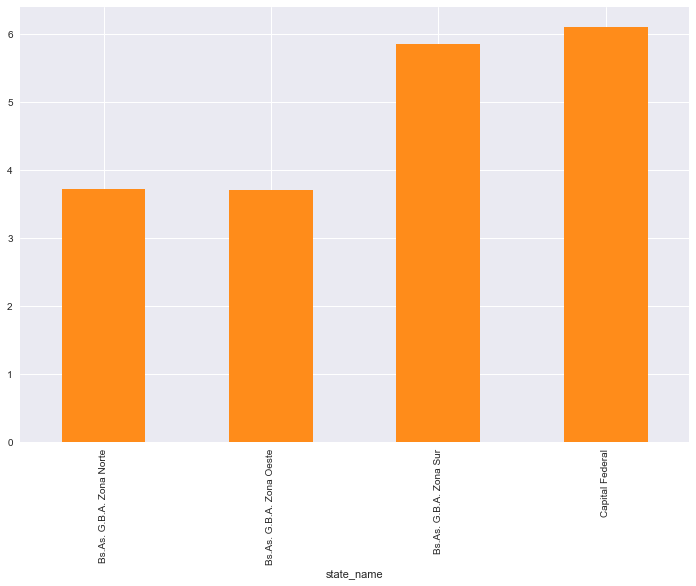

In [12]:
properati_filtrado.groupby('state_name').mean()['floor'].plot(kind='bar',figsize=TAM_IMG,color='#ff8c1a')
titulo = 'Pisos por zona'
guardar_imagen(titulo)
plt.show()

## Cantidad de tipos de propiedades por zona

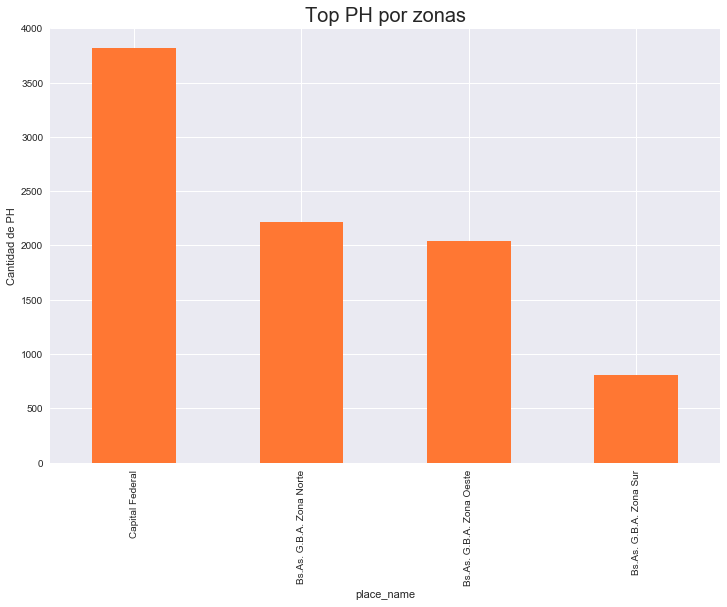

In [13]:
ranking_tipos = properati_filtrado.loc[properati_filtrado['property_type']=='PH'].groupby('state_name').count()['created_on'].sort_values(ascending=False).head(20)
ranking_tipos.plot(kind='bar',figsize=TAM_IMG,color='#ff7733')
titulo = 'Top PH por zonas'
plt.title(titulo,size=20)
plt.xlabel('place_name')
plt.ylabel('Cantidad de PH')
guardar_imagen(titulo)
plt.show()

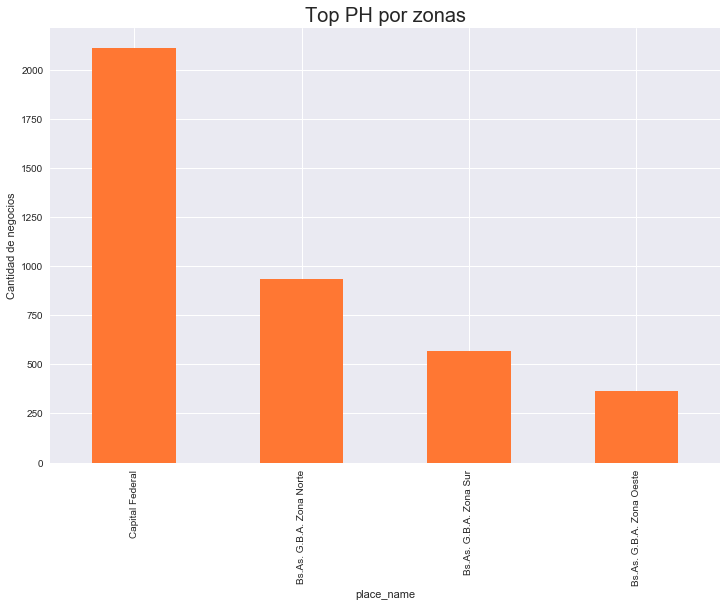

In [14]:
ranking_tipos = properati_filtrado.loc[properati_filtrado['property_type']=='store'].groupby('state_name').count()['created_on'].sort_values(ascending=False).head(20)
ranking_tipos.plot(kind='bar',figsize=TAM_IMG,color='#ff7733')
tiutlo = 'Top negocios por zonas'
plt.title(titulo,size=20)
plt.xlabel('place_name')
plt.ylabel('Cantidad de negocios')
guardar_imagen(titulo)
plt.show()

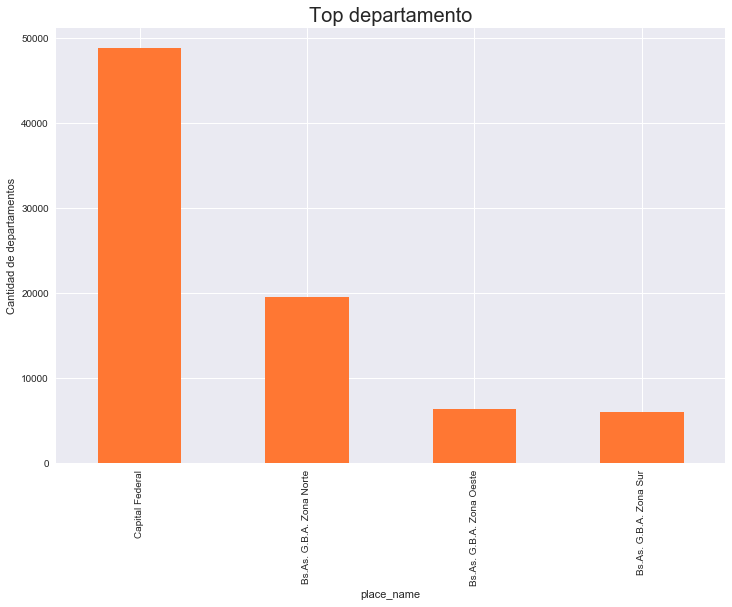

In [15]:
ranking_tipos = properati_filtrado.loc[properati_filtrado['property_type']=='apartment'].groupby('state_name').count()['created_on'].sort_values(ascending=False).head(20)
ranking_tipos.plot(kind='bar',figsize=TAM_IMG,color='#ff7733')
titulo = 'Top departamento por zonas'
plt.title('Top departamento',size=20)
plt.xlabel('place_name')
plt.ylabel('Cantidad de departamentos')
guardar_imagen(titulo)
plt.show()

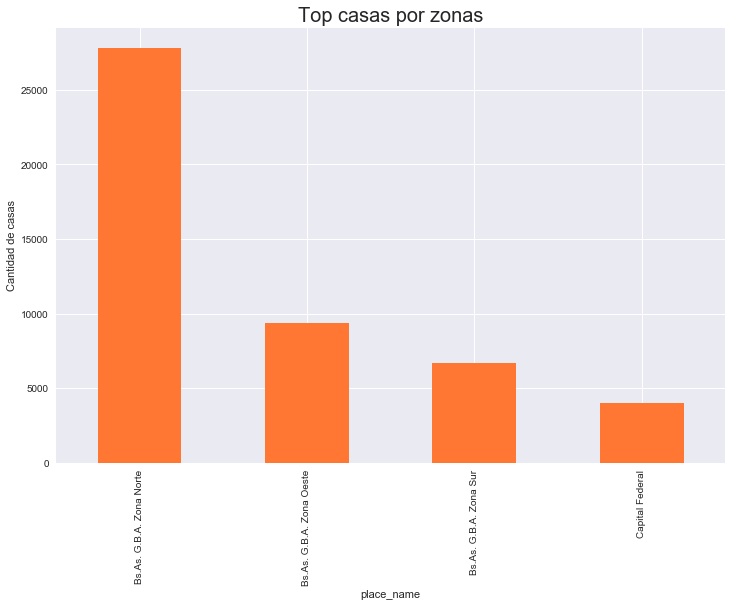

In [16]:
ranking_tipos = properati_filtrado.loc[properati_filtrado['property_type']=='house'].groupby('state_name').count()['created_on'].sort_values(ascending=False).head(20)
ranking_tipos.plot(kind='bar',figsize=TAM_IMG,color='#ff7733')
titulo='Top casas por zonas'
plt.title(titulo,size=20)
plt.xlabel('place_name')
plt.ylabel('Cantidad de casas')
guardar_imagen(titulo)
plt.show()

In [17]:
zona_norte = properati_filtrado.loc[properati_filtrado.state_name.str.contains('Norte')]
zona_sur = properati_filtrado.loc[properati_filtrado.state_name.str.contains('Sur')]
zona_oeste = properati_filtrado.loc[properati_filtrado.state_name.str.contains('Oeste')]
caba = properati_filtrado.loc[properati_filtrado.state_name == 'Capital Federal']

## Ranking precio por m2 por barrios

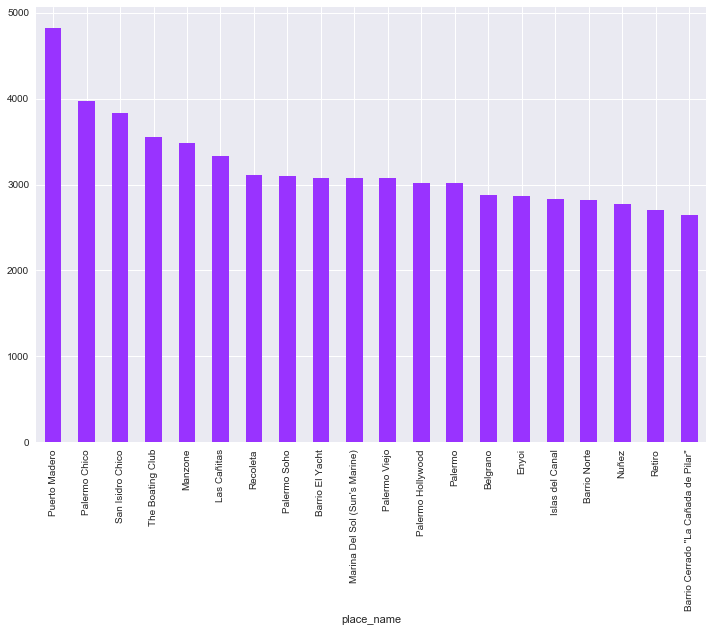

In [18]:
titulo = 'Ranking precio por m2 por barrios'
properati_filtrado.groupby('place_name').mean()['price_usd_per_m2'].sort_values(ascending=False).head(20).plot(kind='bar',figsize=TAM_IMG,color='#9933ff')
guardar_imagen(titulo)
plt.show()

## Ranking precio por m2 de tipo de propiedades por barrios

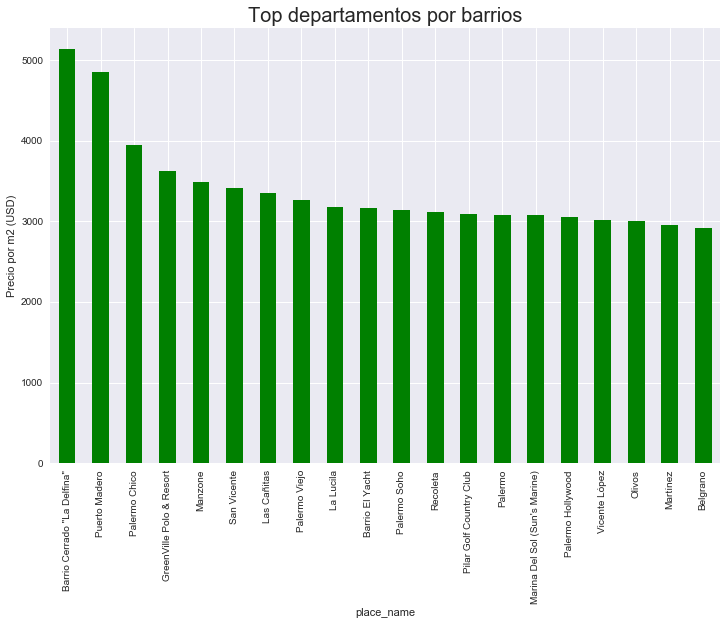

In [19]:
ranking_precios_usd = properati_filtrado.loc[properati_filtrado['property_type']=='apartment'].groupby('place_name').mean()['price_usd_per_m2'].sort_values(ascending=False).head(20)
ranking_precios_usd.plot(kind='bar',figsize=TAM_IMG,color='g')
titulo = 'Top departamentos por barrios'
plt.title(titulo,size=20)
plt.xlabel('place_name')
plt.ylabel('Precio por m2 (USD)')
guardar_imagen(titulo)
plt.show()

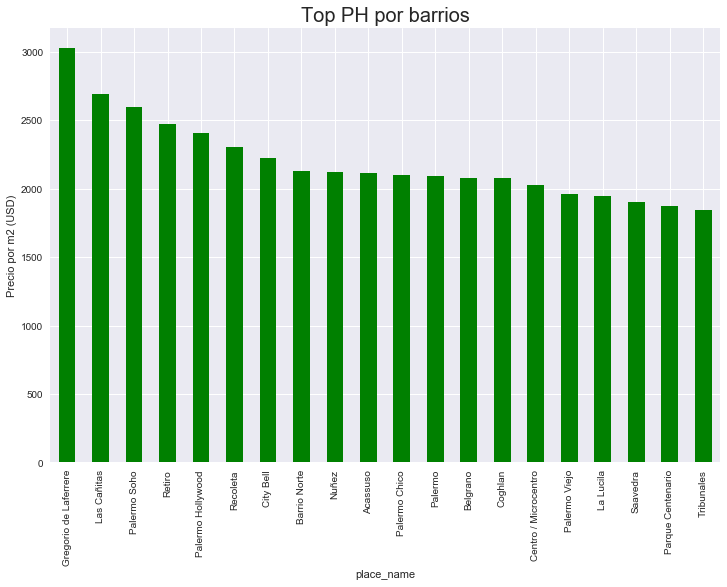

In [20]:
ranking_precios_usd = properati_filtrado.loc[properati_filtrado['property_type']=='PH'].groupby('place_name').mean()['price_usd_per_m2'].sort_values(ascending=False).head(20)
ranking_precios_usd.plot(kind='bar',figsize=TAM_IMG,color='g')
titulo = 'Top PH por barrios'
plt.title(titulo,size=20)
plt.xlabel('place_name')
plt.ylabel('Precio por m2 (USD)')
guardar_imagen(titulo)
plt.show()

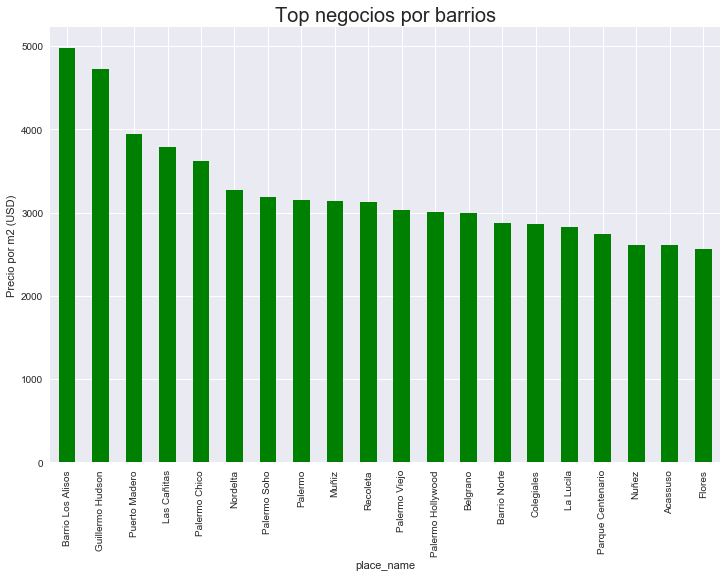

In [21]:
ranking_precios_usd = properati_filtrado.loc[properati_filtrado['property_type']=='store'].groupby('place_name').mean()['price_usd_per_m2'].sort_values(ascending=False).head(20)
ranking_precios_usd.plot(kind='bar',figsize=TAM_IMG,color='g')
titulo = 'Top negocios por barrios'
plt.title(titulo,size=20)
plt.xlabel('place_name')
plt.ylabel('Precio por m2 (USD)')
guardar_imagen(titulo)
plt.show()

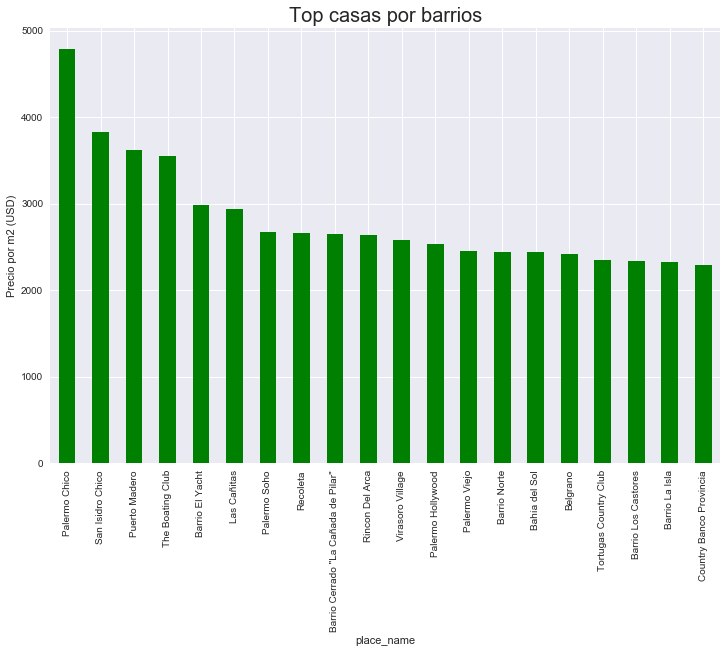

In [22]:
ranking_precios_usd = properati_filtrado.loc[properati_filtrado['property_type']=='house'].groupby('place_name').mean()['price_usd_per_m2'].sort_values(ascending=False).head(20)
ranking_precios_usd.plot(kind='bar',figsize=TAM_IMG,color='g')
titulo = 'Top casas por barrios'
plt.title(titulo,size=20)
plt.xlabel('place_name')
plt.ylabel('Precio por m2 (USD)')
guardar_imagen(titulo)
plt.show()

## Ranking cantidad de propiedades por barrios


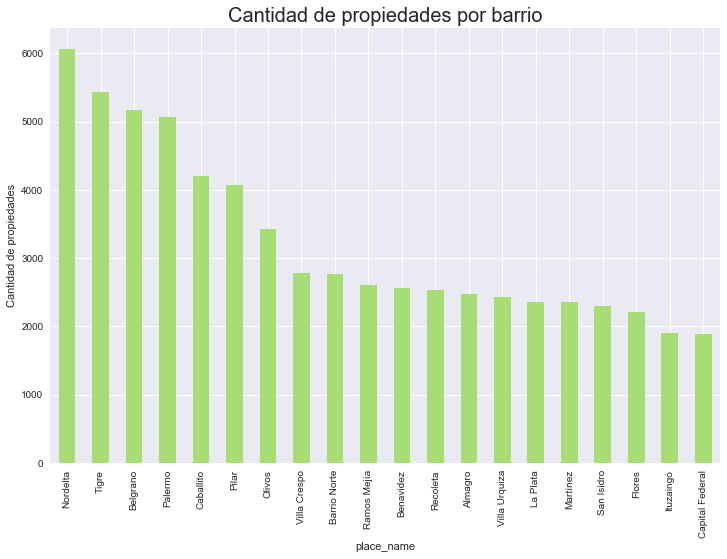

In [23]:
ranking_tipos = properati_filtrado.groupby('place_name').count()['created_on'].sort_values(ascending=False).head(20)
ranking_tipos.plot(kind='bar',figsize=TAM_IMG,color='#a8dc76')
titulo = 'Cantidad de propiedades por barrio'
plt.title(titulo,size=20)
plt.xlabel('place_name')
plt.ylabel('Cantidad de propiedades')
guardar_imagen(titulo)
plt.show()

## Ranking cantidad de tipos de propiedades por barrios

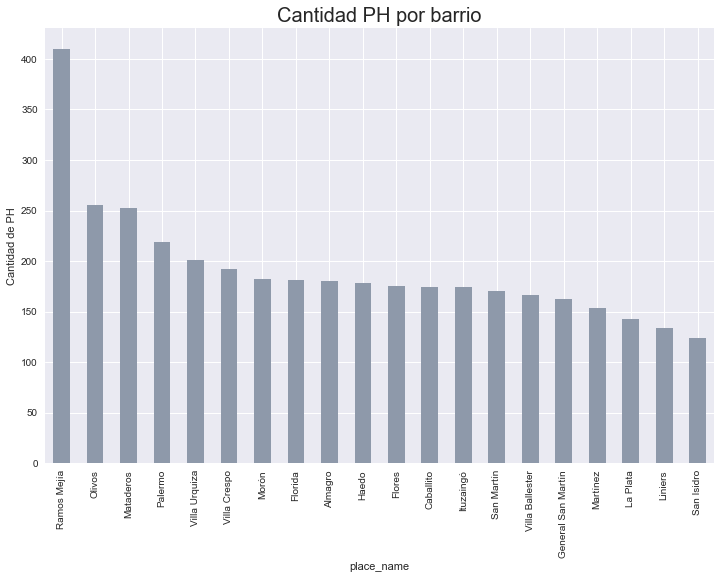

In [24]:
ranking_tipos = properati_filtrado.loc[properati_filtrado['property_type']=='PH'].groupby('place_name').count()['created_on'].sort_values(ascending=False).head(20)
ranking_tipos.plot(kind='bar',figsize=TAM_IMG,color='#8e99aa')
titulo = 'Cantidad PH por barrio'
plt.title(titulo,size=20)
plt.xlabel('place_name')
plt.ylabel('Cantidad de PH')
guardar_imagen(titulo)
plt.show()

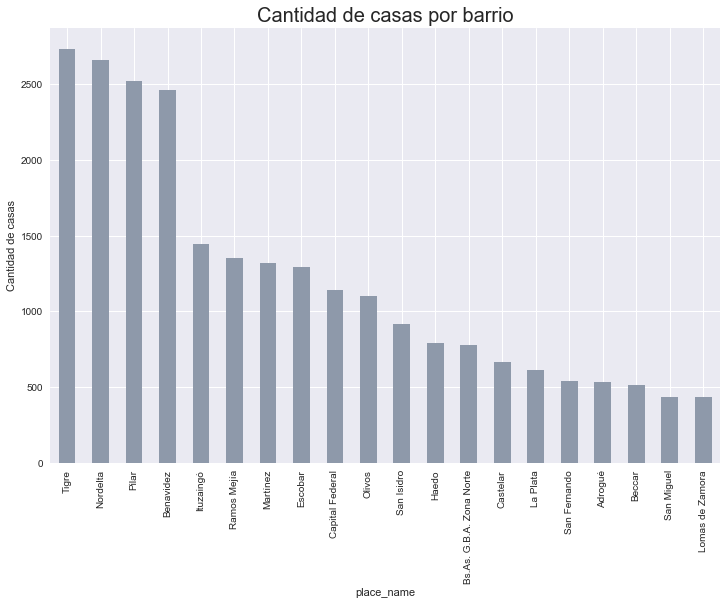

In [25]:
ranking_tipos = properati_filtrado.loc[properati_filtrado['property_type']=='house'].groupby('place_name').count()['created_on'].sort_values(ascending=False).head(20)
ranking_tipos.plot(kind='bar',figsize=TAM_IMG,color='#8e99aa')
titulo = 'Cantidad de casas por barrio'
plt.title(titulo,size=20)
plt.xlabel('place_name')
plt.ylabel('Cantidad de casas')
guardar_imagen(titulo)
plt.show()

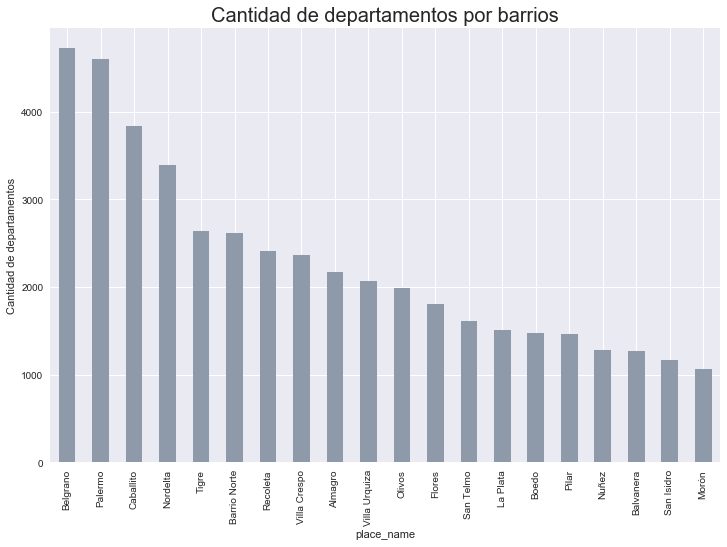

In [26]:
ranking_tipos = properati_filtrado.loc[properati_filtrado['property_type']=='apartment'].groupby('place_name').count()['created_on'].sort_values(ascending=False).head(20)
ranking_tipos.plot(kind='bar',figsize=TAM_IMG,color='#8e99aa')
titulo = 'Cantidad de departamentos por barrios'
plt.title(titulo,size=20)
plt.xlabel('place_name')
plt.ylabel('Cantidad de departamentos')
guardar_imagen(titulo)
plt.show()

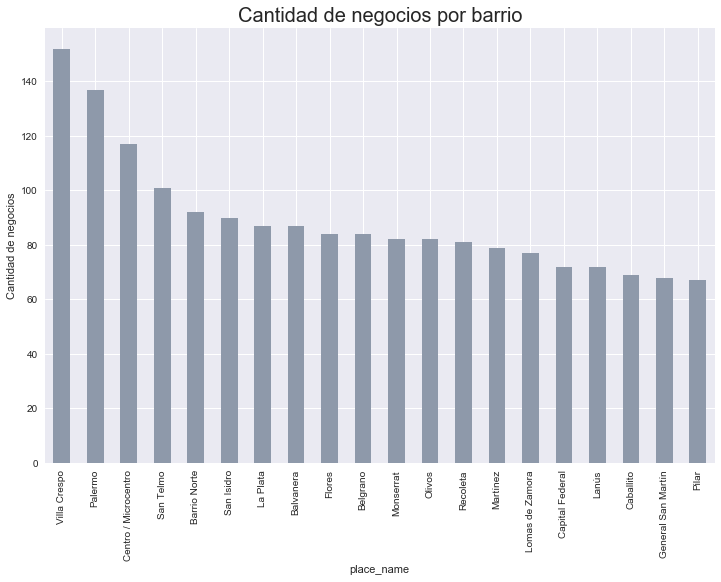

In [27]:
ranking_tipos = properati_filtrado.loc[properati_filtrado['property_type']=='store'].groupby('place_name').count()['created_on'].sort_values(ascending=False).head(20)
ranking_tipos.plot(kind='bar',figsize=TAM_IMG,color='#8e99aa')
titulo='Cantidad de negocios por barrio'
plt.title(titulo,size=20)
plt.xlabel('place_name')
plt.ylabel('Cantidad de negocios')
guardar_imagen(titulo)
plt.show()

In [28]:
propiedades_full=properati
propiedades_full.columns

Index([u'created_on', u'operation', u'property_type', u'place_name',
       u'place_with_parent_names', u'country_name', u'state_name',
       u'geonames_id', u'lat-lon', u'lat', u'lon', u'price', u'currency',
       u'price_aprox_local_currency', u'price_aprox_usd',
       u'surface_total_in_m2', u'surface_covered_in_m2', u'price_usd_per_m2',
       u'price_per_m2', u'floor', u'rooms', u'expenses', u'properati_url',
       u'description', u'title', u'image_thumbnail'],
      dtype='object')

In [29]:
properties_by_type=propiedades_full[['place_name','property_type']]


In [30]:
properties_by_type_and_total=properties_by_type.groupby('place_name').count().reset_index()

In [31]:
properties_by_type_and_total.columns=['place_name','total_properties']
properties_by_type_and_total

,place_name,total_properties
0,Country Maschwitz Club,34
1,los alamos,2
2,9 de Abril,4
3,Abasto,312
4,Abril Club de Campo,49
5,Acacias Blancas,94
6,Acassuso,851
7,Adrogué,1346
8,Aero Country Club,4
9,Aeropuerto Internacional Ezeiza,8


In [32]:
properties_by_type=properties_by_type.groupby('place_name').apply(lambda x: x['property_type'].value_counts()).reset_index()
properties_by_type=pd.pivot_table(properties_by_type,index=['place_name'],columns=['level_1']).reset_index()
properties_by_type

place_name property_type                   \
level_1                                                PH apartment  house   
0                    Country Maschwitz Club           NaN       NaN   34.0   
1                                los alamos           NaN       1.0    1.0   
2                                9 de Abril           NaN       NaN    2.0   
3                                    Abasto          28.0     233.0   26.0   
4                       Abril Club de Campo           NaN       NaN   49.0   
5                           Acacias Blancas           NaN       NaN   94.0   
6                                  Acassuso          24.0     301.0  481.0   
7                                   Adrogué          47.0     357.0  888.0   
8                         Aero Country Club           NaN       4.0    NaN   
9           Aeropuerto Internacional Ezeiza           NaN       NaN    8.0   
10                                Agronomía          22.0     142.0   13.0   
11                 Albanueva Barrio Cerrado           NaN      17.0   18.0   
12                               Aldo Bonzi           3.0       4.0   15.0   
13                           Alejandro Korn           NaN       1.0   27.0   
14                         Alejandro Petión           NaN       NaN    4.0   
15                                  Almagro         218.0    2692.0   81.0   
16                          Almirante Brown           3.0      26.0   69.0   
17                                 Altamira           NaN       NaN   24.0   
18                        Altos de Hudson I           NaN       1.0    3.0   
19                       Altos de Hudson II           NaN      14.0   12.0   
20                Altos de Manzanares 1 y 2           NaN       NaN    7.0   
21                          Altos de Matheu           NaN       NaN    6.0   
22                           Altos del Golf           NaN       NaN   17.0   
23                          Altos del Pilar           NaN       NaN   22.0   
24                     Armenia Country Club           NaN       NaN    6.0   
25                             Arturo Seguí           NaN       NaN   15.0   
26                               Avellaneda          65.0     524.0  114.0   
27                            Bahía del Sol           NaN       1.0    4.0   
28                                Balvanera         140.0    1823.0   31.0   
29                                 Banfield          84.0     698.0  718.0   
..                                      ...           ...       ...    ...   
585                          Villa Numancia           NaN       NaN    1.0   
586                           Villa Ortuzar          30.0     180.0   18.0   
587                           Villa Pacheco           NaN       NaN    8.0   
588                        Villa Pueyrredón         135.0     340.0  113.0   
589                             Villa Raffo          12.0      39.0   14.0   
590                              Villa Real          53.0      52.0   38.0   
591                         Villa Riachuelo           3.0       1.0    4.0   
592                              Villa Rosa           3.0     107.0   89.0   
593                          Villa San Luis           NaN       NaN    1.0   
594                        Villa Santa Rita          39.0     149.0   40.0   
595                         Villa Sarmiento          70.0     300.0  230.0   
596                           Villa Soldati           8.0      27.0    6.0   
597                             Villa Tesei           7.0      28.0   79.0   
598                           Villa Udaondo           6.0       2.0  228.0   
599                           Villa Urquiza         293.0    2901.0  202.0   
600                          Villa Vatteone           1.0       1.0    6.0   
601                           Villa de Mayo           1.0      26.0   78.0   
602                        Villa del Parque         119.0     851.0  144.0   
603      Village Golf & Tennis Country Club           N

In [33]:
 properties_by_type.columns=['place_name','PH','apartment','house','store']

In [34]:
properties_by_type_and_total=pd.merge(properties_by_type,properties_by_type_and_total,on = 'place_name', how='left')

In [35]:
properties_by_type_and_total_mean=properties_by_type_and_total

In [36]:
properties_by_type_and_total_mean=properties_by_type_and_total_mean.fillna(value=0)

In [37]:
properties_by_type_and_total_mean.loc[:,('apartment_percent')]=properties_by_type_and_total_mean['apartment']/properties_by_type_and_total_mean['total_properties']
properties_by_type_and_total_mean.loc[:,('PH_percent')]=properties_by_type_and_total_mean['PH']/properties_by_type_and_total_mean['total_properties']
properties_by_type_and_total_mean.loc[:,('house_percent')]=properties_by_type_and_total_mean['house']/properties_by_type_and_total_mean['total_properties']
properties_by_type_and_total_mean.loc[:,('store_percent')]=properties_by_type_and_total_mean['store']/properties_by_type_and_total_mean['total_properties']

In [38]:
properties_by_type_and_total_mean

,place_name,PH,apartment,house,store,total_properties,apartment_percent,PH_percent,house_percent,store_percent
0,Country Maschwitz Club,0.0,0.0,34.0,0.0,34,0.000000,0.000000,1.000000,0.000000
1,los alamos,0.0,1.0,1.0,0.0,2,0.500000,0.000000,0.500000,0.000000
2,9 de Abril,0.0,0.0,2.0,2.0,4,0.000000,0.000000,0.500000,0.500000
3,Abasto,28.0,233.0,26.0,25.0,312,0.746795,0.089744,0.083333,0.080128
4,Abril Club de Campo,0.0,0.0,49.0,0.0,49,0.000000,0.000000,1.000000,0.000000
5,Acacias Blancas,0.0,0.0,94.0,0.0,94,0.000000,0.000000,1.000000,0.000000
6,Acassuso,24.0,301.0,481.0,45.0,851,0.353702,0.028202,0.565217,0.052879
7,Adrogué,47.0,357.0,888.0,54.0,1346,0.265230,0.034918,0.659733,0.040119
8,Aero Country Club,0.0,4.0,0.0,0.0,4,1.000000,0.000000,0.000000,0.000000
9,Aeropuerto Internacional Ezeiza,0.0,0.0,8.0,0.0,8,0.000000,0.000000,1.000000,0.000000


In [39]:
properties_by_usd_m2=propiedades_full[['place_name','price_usd_per_m2']].dropna().groupby('place_name').mean().reset_index()

In [40]:
properties_by_m2_and_type_mean=pd.merge(properties_by_usd_m2,properties_by_type_and_total_mean,on='place_name',how='left')

## Lo de abajo lo comente porque tiraba warnings y hacia cosas raras para los graficos de despues

In [41]:
#properties_by_m2_and_type_mean_greater_than_20 = properties_by_m2_and_type_mean[properties_by_m2_and_type_mean['total_properties']>20]\
#[['apartment_percent','house_percent','PH_percent','store_percent','price_usd_per_m2']].groupby('price_usd_per_m2')
#properties_by_m2_and_type_mean_greater_than_20.plot(kind='line',marker='o',figsize=TAM_IMG);
#plt.show()
#properties_by_m2_and_type_mean_greater_than_20


## propiedades con patio y a estrenar

In [42]:
news_properties_with_garden=pd.DataFrame({'place_name':propiedades_full['place_name']\
                                          ,'description':propiedades_full['description'],'price_usd_per_m2':propiedades_full['price_usd_per_m2']})


In [43]:
news_properties_with_garden=news_properties_with_garden.dropna(how='any')

In [44]:
news_properties_with_garden.loc[:,'has_garden']=news_properties_with_garden.loc[:,'description'].str.lower().str.contains('patio')
news_properties_with_garden.loc[:,'is_new']=news_properties_with_garden.loc[:,'description'].str.lower().str.contains('estrenar')

In [45]:
news_properties_with_garden.sort_values(by='price_usd_per_m2',ascending=False).loc[:10]

,description,place_name,price_usd_per_m2,has_garden,is_new
33850,Popopopo - Publicado a traves de VisualGestion -,Capital Federal,1271027.0,False,False
127950,Departamento 1 ambiente divisible Depto en CU...,Boedo,206333.0,False,False
127590,lan840- DEPTO FINANCIACION DIRECTA EN PESOSAnt...,Boedo,173826.0,False,False
48988,Venta de Departamento 3 AMBIENTES en TigreLind...,Tigre,142333.0,False,False
127685,fac030- Depto anticipo en 10 meses y saldo en ...,Boedo,104486.0,False,False
205683,"CODIGO: ubicado en: MONSEÑOR TERRERO , Ituzai...",Ituzaingó,80000.0,True,False
127474,bf221- INCREIBLE FORMA DE PAGO- ANT Y CUOTAS D...,Boedo,78533.0,False,False
156726,"COMPRA EN AQUA RIO, EXCELENTE EMPRENDIMIENTO E...",Tigre,69710.0,False,False
97353,Emprendimiento con fecha de entregar Julio del...,Olivos,61486.0,False,False
47159,Excelente Semipiso en lo mejor de Belgrano Chi...,Belgrano,54990.0,False,False


## Veamos cuales son las ciudades que vendieron más casas con patio

In [46]:
properties_total=propiedades_full[['place_name','property_type']]
#Calculo el total de las ventas por ciudad
properties_total=properties_total.groupby('place_name').count().reset_index()

In [47]:
properties_total.columns=['place_name','total']

In [48]:
#Calculo la cantidad de casas con jardines vendidas por ciudad
properties_garden_count=news_properties_with_garden[['place_name','has_garden']][news_properties_with_garden['has_garden']]\
.groupby('place_name').count().reset_index()

In [49]:
#Merge entre cantidad de casas con jardines con cantidad total de casas
properties_garden_count=pd.merge(properties_garden_count,properties_total,on='place_name',how='left')

In [50]:
properties_garden_count.loc[:,('has_garden_percent')]=properties_garden_count['has_garden']/properties_garden_count['total']

In [51]:
#Elimino los datos con menores a 50 ventas.
properties_garden_count=properties_garden_count[properties_garden_count['total']>50]

In [52]:
properties_garden_count.sort_values(by='has_garden_percent',ascending=False)

,place_name,has_garden,total,has_garden_percent
298,Villa Libertad,39,70,0.557143
52,Billinghurst,22,51,0.431373
303,Villa Madero,41,106,0.386792
66,Carapachay,142,371,0.382749
276,Valentín Alsina,143,419,0.341289
154,La Tablada,42,125,0.336000
260,Sarandi,33,100,0.330000
139,Jose Leon Suarez,66,203,0.325123
302,Villa Lynch,36,113,0.318584
184,Mataderos,361,1142,0.316112


## Mismo análisis con propiedades a estrenar

In [53]:
#Calculo la cantidad de casas con jardines vendidas por ciudad
news_properties_count=news_properties_with_garden[['place_name','is_new']][news_properties_with_garden['is_new']]\
.groupby('place_name').count().reset_index()
#Merge entre cantidad de casas a estrenar con cantidad total de casas
news_properties_count=pd.merge(news_properties_count,properties_total,on='place_name',how='left')


In [54]:
news_properties_count.loc[:,('is_new_percent')]=news_properties_count['is_new']/news_properties_count['total']

In [55]:
#Elimino los datos con menores a 50 ventas.
news_properties_count=news_properties_count[news_properties_count['total']>50]
news_properties_count.sort_values(by='is_new_percent',ascending=False)

,place_name,is_new,total,is_new_percent
248,Sáenz Peña,103,299,0.344482
33,Barrio La Alameda,22,95,0.231579
79,Caseros,400,1963,0.203770
244,Santos Lugares,86,448,0.191964
10,Avellaneda,142,740,0.191892
284,Villa Ortuzar,45,241,0.186722
88,Coghlan,114,619,0.184168
138,Haras Santa Maria,48,271,0.177122
207,Parque Chas,22,129,0.170543
53,Barrio San Gabriel,29,178,0.162921


## Cual es el tipo de propiedad que se vende mas?  REVISAR PORQUE TIRA 2532 GRAFICOS

In [56]:
top_tipos=properati_filtrado.groupby('property_type')['price'].count().sort_values()
top_tipos

property_type
store         3972
PH            8875
house        47867
apartment    80609
Name: price, dtype: int64

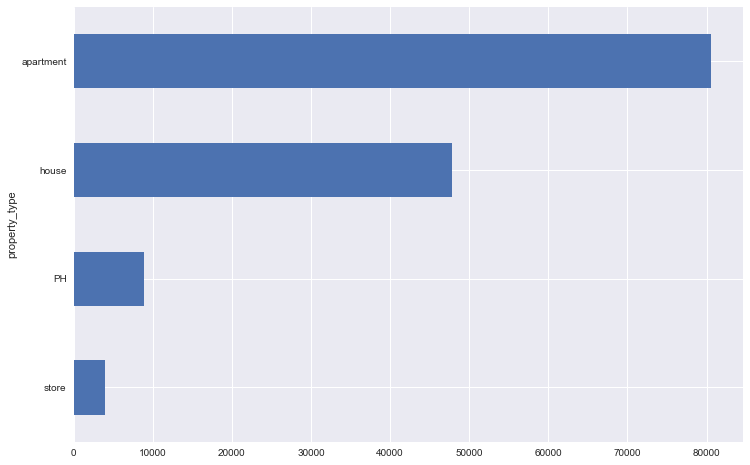

In [57]:
top_tipos.plot(kind='barh',figsize=TAM_IMG)
#plt.set_ylabel('Tipo')
#plt.set_xlabel('Cantidad')
plt.show()

## Promedio de precio por tipo

In [58]:
promedio_por_tipo = properati_filtrado.groupby('property_type')['price_usd_per_m2'].mean()

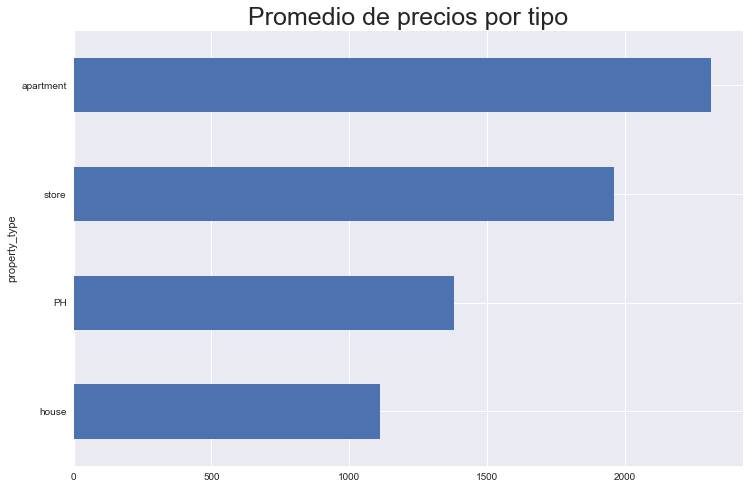

In [59]:
promedio_por_tipo.sort_values().plot(kind='barh',figsize=TAM_IMG)
titulo = 'Promedio de precios por tipo'
plt.title(titulo,size=25)
guardar_imagen(titulo)
plt.show()

## Promedio precio por m2 por mes

In [60]:
properati_filtrado['fecha'] = [(x.year,x.month) for x in properati_filtrado['created_on'] ]
propiedades_por_mes = properati_filtrado.loc[properati_filtrado['fecha']>(2015,1)]
propiedades_por_mes = propiedades_por_mes.groupby(['property_type',properati_filtrado['fecha']])

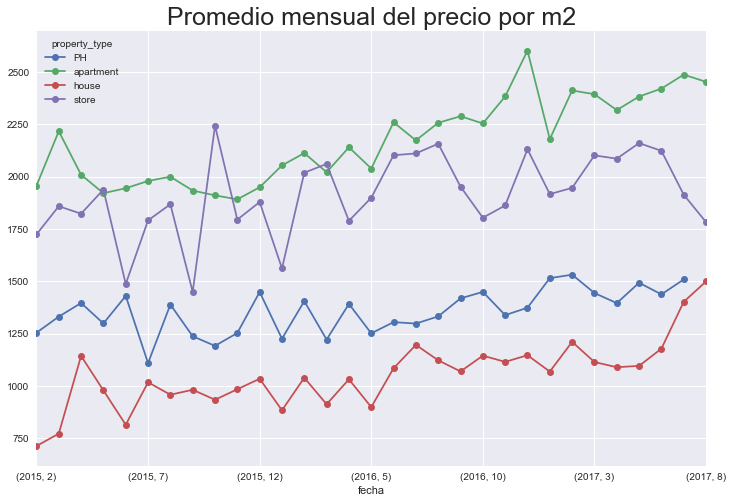

In [61]:
promedio_por_tipo_y_mes= propiedades_por_mes['price_usd_per_m2'].mean().unstack(level=0)
promedio_por_tipo_y_mes.plot(kind='line',marker="o",figsize=TAM_IMG)
titulo = 'Promedio mensual del precio por m2'
plt.title(titulo,size=25)
guardar_imagen(titulo)
plt.show()

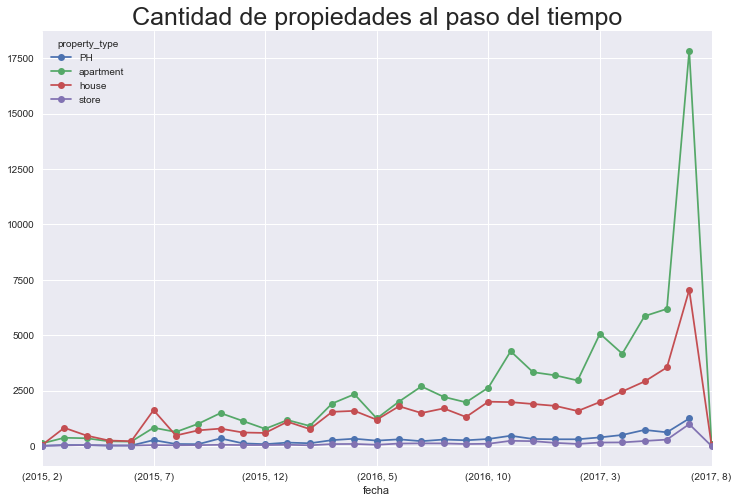

In [62]:
cantidad_por_mes = propiedades_por_mes.count()['created_on'].unstack(level=0)
cantidad_por_mes.plot(kind='line',marker="o",figsize=TAM_IMG)
titulo = 'Cantidad de propiedades al paso del tiempo'
plt.title(titulo,size=25)
guardar_imagen(titulo)
plt.show()

## Cantidad de pisos a traves del tiempo

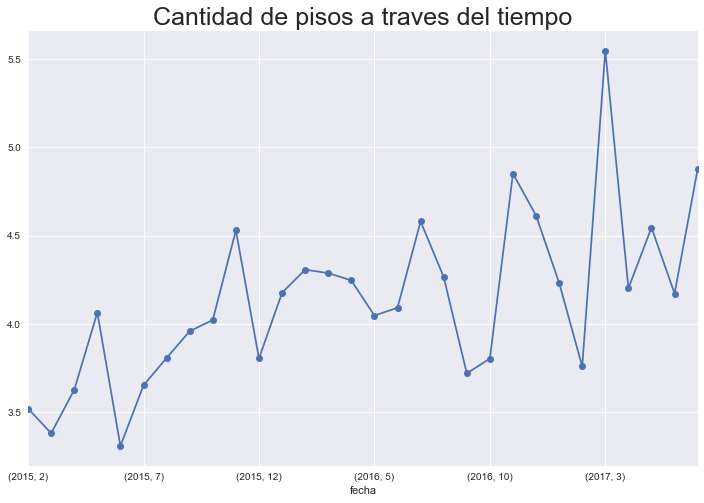

In [63]:
pisos_vs_tiempo = properati_filtrado.loc[properati_filtrado.floor < 55] #https://es.wikipedia.org/wiki/Anexo:Edificios_m%C3%A1s_altos_de_Argentina
pisos_vs_tiempo = pisos_vs_tiempo.loc[pisos_vs_tiempo['fecha']>(2015,1)]
pisos_vs_tiempo.groupby('fecha').mean()['floor'].plot(kind='line',marker="o",figsize=TAM_IMG)
titulo = 'Cantidad de pisos a traves del tiempo'
plt.title(titulo,size=25)
guardar_imagen(titulo)
plt.show()

##  Mayor cantidad de publicaciones respecto de las expensas y el precio total

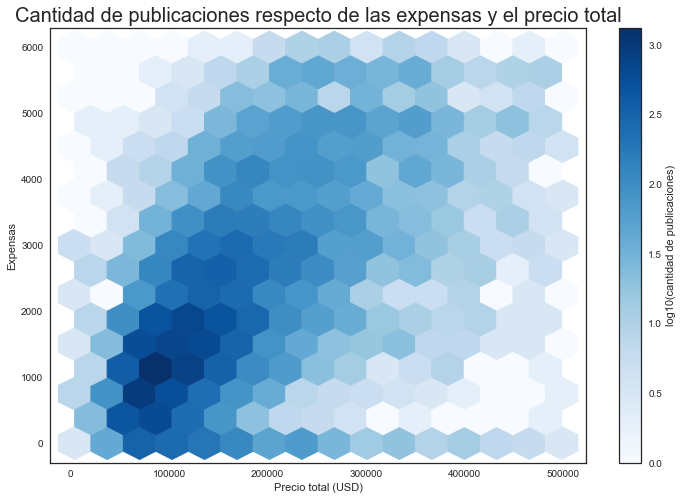

In [64]:
expensas_vs_precio = properati_filtrado.loc[(properati_filtrado['property_type'] == 'apartment') & (properati_filtrado.expenses<6000) & (properati_filtrado.expenses>0) & (properati_filtrado.price_aprox_usd <500000)].loc[:,('price_aprox_usd','expenses')].dropna() #hay unas expensas mal
plt.figure(figsize=TAM_IMG)
sns.set_style("white")
plt.hexbin(expensas_vs_precio['price_aprox_usd'],expensas_vs_precio['expenses'], gridsize=15,bins='log',cmap='Blues')
cb = plt.colorbar()
cb.set_label('log10(cantidad de publicaciones)')
titulo = 'Cantidad de publicaciones respecto de las expensas y el precio total'
plt.title(titulo,size=20)
plt.ylabel('Expensas')
plt.xlabel('Precio total (USD)')
guardar_imagen(titulo)
plt.show()

##  Mayor cantidad de publicaciones respecto de las expensas y el precio por m2

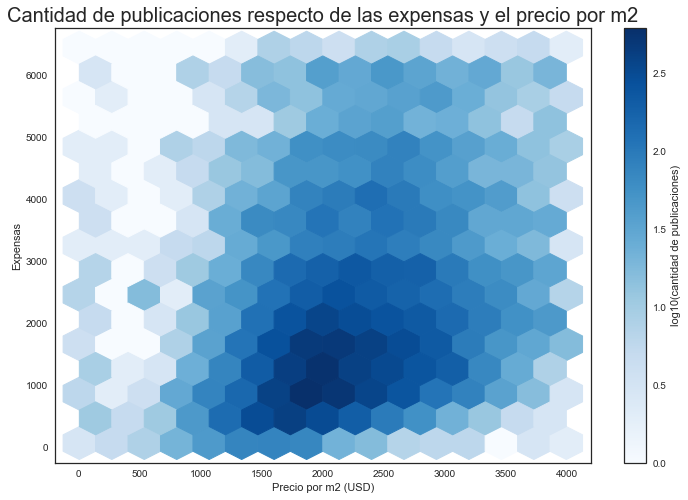

In [65]:
expensas_vs_precio = properati_filtrado.loc[(properati_filtrado['property_type'] == 'apartment') & (properati_filtrado.price_usd_per_m2<4000) & (properati_filtrado.expenses>50) & (properati_filtrado.expenses<6500)].loc[:,('price_usd_per_m2','expenses')].dropna() #hay unas expensas mal
plt.figure(figsize=TAM_IMG)
sns.set_style("white")
plt.hexbin(expensas_vs_precio['price_usd_per_m2'],expensas_vs_precio['expenses'], gridsize=15,bins='log',cmap='Blues')
cb = plt.colorbar()
cb.set_label('log10(cantidad de publicaciones)')
titulo = 'Cantidad de publicaciones respecto de las expensas y el precio por m2'
plt.title(titulo,size=20)
plt.ylabel('Expensas')
plt.xlabel('Precio por m2 (USD)')
guardar_imagen(titulo)
plt.show()

##  Superficie descubierta vs precio 

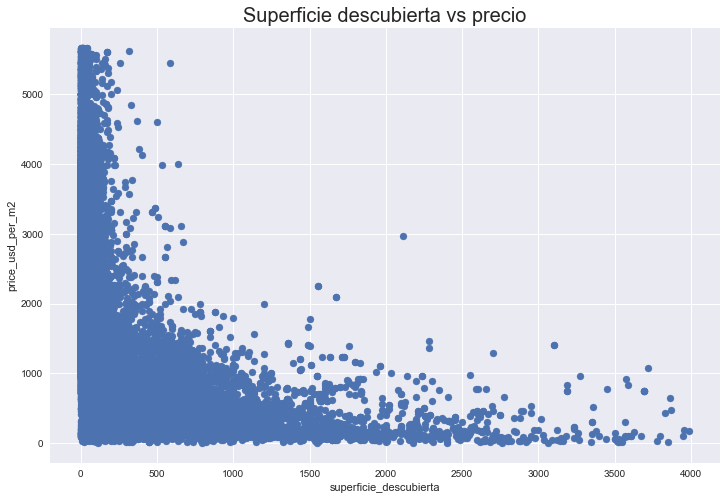

In [66]:
properati_filtrado.loc[:,'superficie_descubierta'] = properati_filtrado['surface_total_in_m2'] - properati_filtrado['surface_covered_in_m2']
properati_filtrado.loc[:,'superficie_descubierta'] = properati_filtrado.loc[properati_filtrado.superficie_descubierta>0 &((properati_filtrado.property_type == "PH")|(properati_filtrado.property_type == "apartment"))]
precio_vs_descubierto= properati_filtrado.loc[:,('price_usd_per_m2','superficie_descubierta')].dropna()
precio_vs_descubierto.groupby('superficie_descubierta').mean()
precio_vs_descubierto = precio_vs_descubierto.loc[precio_vs_descubierto.superficie_descubierta<4000]

sns.set_style("darkgrid")
plt.figure(figsize=TAM_IMG)
plt.scatter(precio_vs_descubierto['superficie_descubierta'],precio_vs_descubierto['price_usd_per_m2'])
titulo='Superficie descubierta vs precio'
plt.title(titulo,size=20)
plt.ylabel('price_usd_per_m2')
plt.xlabel('superficie_descubierta')
guardar_imagen(titulo)
plt.show()

##  Precio por m2 vs habitaciones

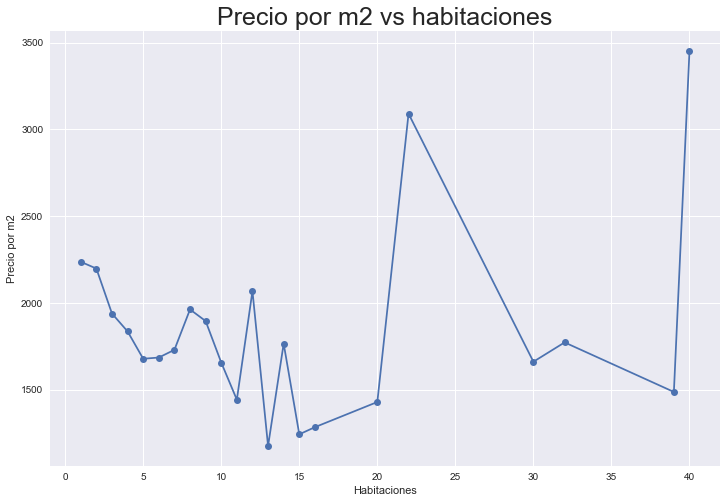

In [67]:
precio_vs_habs= properati_filtrado.loc[:,('price_usd_per_m2','rooms')].dropna()
precio_vs_habs= precio_vs_habs.groupby('rooms').mean()

titulo ='Precio por m2 vs habitaciones'
plt.figure(figsize=TAM_IMG)
plt.xlabel('Habitaciones')
plt.ylabel('Precio por m2')
plt.title(titulo,size= 25)
plt.plot(precio_vs_habs,marker="o")
guardar_imagen(titulo)
plt.show()

## Precio m2 vs años para cada tipo

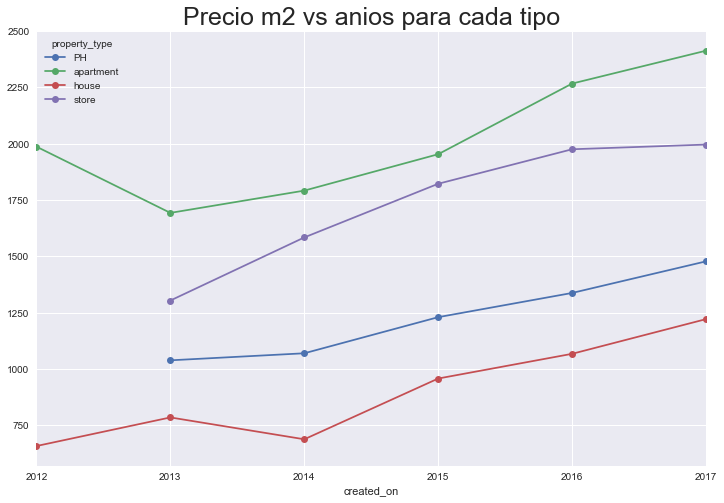

In [70]:
m2_anual = properati_filtrado.groupby([properati_filtrado.property_type,properati_filtrado.created_on.dt.year]).mean()['price_usd_per_m2'].unstack(level=0)
m2_anual.plot(kind='line',marker="o",figsize=TAM_IMG)

titulo = 'Precio m2 vs anios para cada tipo'
plt.title(titulo,size=25)
guardar_imagen(titulo)
plt.show()

##  Piso del departamento vs precio por m2

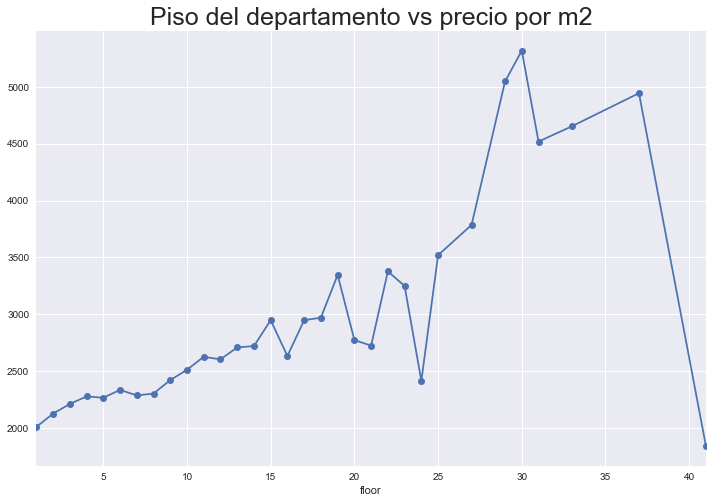

In [71]:
piso_vs_precio = properati_filtrado.loc[:,('price_usd_per_m2','floor')].dropna()
piso_vs_precio = piso_vs_precio.loc[piso_vs_precio.floor < 55] #https://es.wikipedia.org/wiki/Anexo:Edificios_m%C3%A1s_altos_de_Argentina
piso_vs_precio = piso_vs_precio.groupby(properati_filtrado.floor)
piso_vs_precio = piso_vs_precio.mean()['price_usd_per_m2']
piso_vs_precio.plot(kind='line',marker="o",figsize=TAM_IMG)

titulo ='Piso del departamento vs precio por m2'
plt.title(titulo,size=25)
guardar_imagen(titulo)
plt.show()

##  Piso del departamento vs expensas

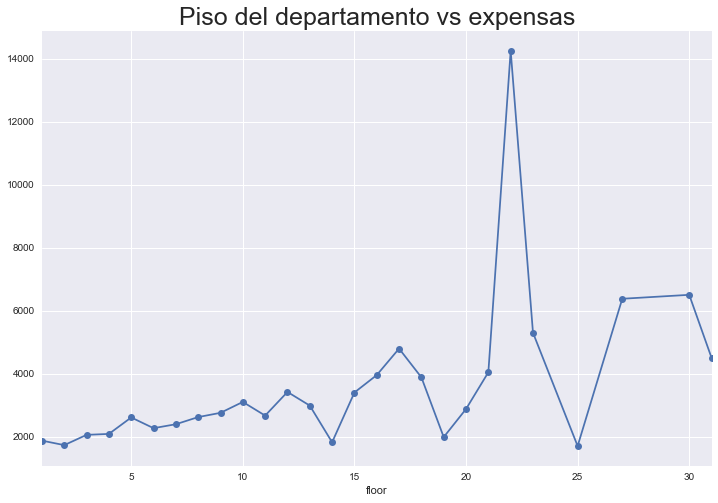

In [72]:
piso_vs_expensas = properati_filtrado.loc[:,('floor','expenses')].dropna(subset=['expenses'])
piso_vs_expensas = piso_vs_expensas.loc[properati_filtrado.floor <50]
piso_vs_expensas = piso_vs_expensas.groupby(properati_filtrado.floor).mean()['expenses']
piso_vs_expensas.plot(kind='line',marker="o",figsize=TAM_IMG)

titulo = 'Piso del departamento vs expensas'
plt.title(titulo,size=25)
guardar_imagen(titulo)
plt.show()

In [73]:
caba_para_mapa = caba.dropna(subset= ['lat','lon'])
caba_para_mapa = caba_para_mapa.loc[(caba_para_mapa.lat > -35) & (caba_para_mapa.lat < -34) & (caba_para_mapa.lon > -58.7)] #preparo para calcular distancias
caba_para_mapa['lat-lon'] = [(x, y) for x,y in zip(caba_para_mapa['lat'], caba_para_mapa['lon'])] #preparo para calcular distancias
#gp.scatter(caba_para_mapa['lat'], caba_para_mapa['lon'],colors='blue') #reviso si filtre bien "puntos malos"

In [74]:
todo_para_mapa = properati_filtrado.dropna(subset= ['lat','lon'])
todo_para_mapa['lat-lon'] = [(x, y) for x,y in zip(todo_para_mapa['lat'], todo_para_mapa['lon'])] #preparo para calcular distancias
todo_para_mapa = todo_para_mapa.loc[(todo_para_mapa.lat > -36) & (todo_para_mapa.lat < -34.2) & (todo_para_mapa.lon > -59)] 
#gp.scatter(todo_para_mapa['lat'], todo_para_mapa['lon'],colors='blue') #reviso si filtre bien "puntos malos"

/home/ale/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Relacion entre distancia a boca de subte vs precio por m2 CABA

In [75]:
subtes = pd.read_csv('datos/datasets/CABA/latlon/estaciones-de-subte.csv')
subtes['lat-lon'] = [(x, y) for x,y in zip(subtes['y'], subtes['x'])]

In [76]:
#gp.scatter(subtes['y'], subtes['x'],colors='red')

In [79]:
caba_para_mapa['dist_a_subte'] = [distancia_minima(x, list(subtes['lat-lon'])) for x in caba_para_mapa['lat-lon']]

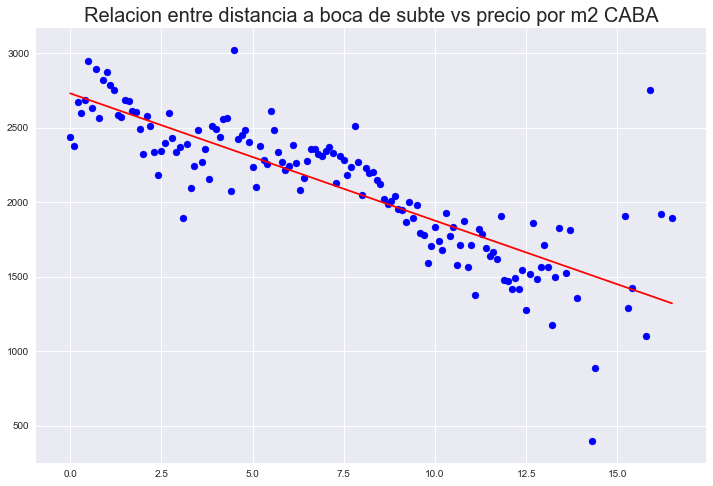

In [80]:
resultados = caba_para_mapa.loc[:,('dist_a_subte','price_usd_per_m2')].groupby('dist_a_subte').mean().reset_index()
titulo = 'Relacion entre distancia a boca de subte vs precio por m2 CABA'
plotear_distancias(resultados,'dist_a_subte','price_usd_per_m2',titulo)

In [81]:
colectivos = pd.read_csv('datos/datasets/CABA/latlon/paradas-de-colectivo.csv')

In [82]:
#gp.scatter(colectivos['Y'], colectivos['X'],colors='red')

In [83]:
metrobus = pd.read_csv('datos/datasets/CABA/latlon/estaciones-de-metrobus.csv')

In [84]:
#gp.scatter(metrobus['Y'], metrobus['X'],colors='red')

In [85]:
trenes = pd.read_csv('datos/datasets/CABA/latlon/estaciones-de-ferrocarril.csv',error_bad_lines=False)
trenes['lat-lon'] = [(x, y) for x,y in zip(trenes['LAT'], trenes['LNG'])]

In [86]:
#gp.scatter(trenes['LAT'], trenes['LNG'],colors='red')

## Relacion entre distancia a estacion de tren vs precio por m2 CABA

In [87]:
caba_para_mapa['dist_a_tren'] = [distancia_minima(x, list(trenes['lat-lon'])) for x in caba_para_mapa['lat-lon']]

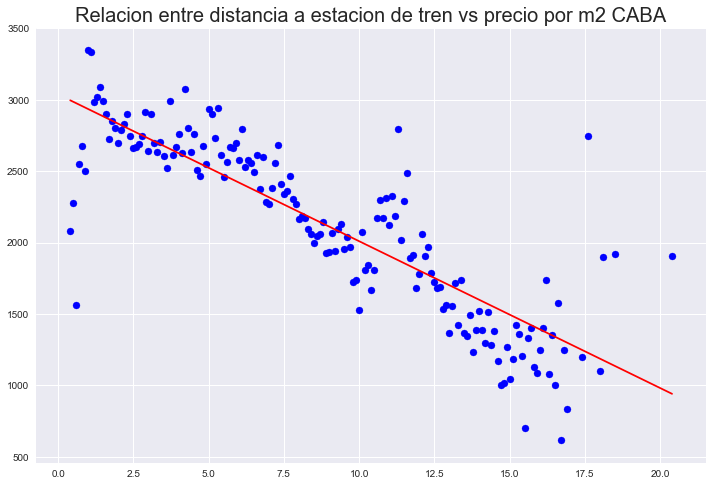

In [88]:
resultados = caba_para_mapa.loc[:,('dist_a_tren','price_usd_per_m2')].groupby('dist_a_tren').mean().reset_index()
titulo = 'Relacion entre distancia a estacion de tren vs precio por m2 CABA'
plotear_distancias(resultados,'dist_a_tren','price_usd_per_m2',titulo)

## Relacion entre distancia a una universidad vs precio por m2 CABA

In [89]:
univ = pd.read_csv('datos/datasets/CABA/latlon/universidades.csv',error_bad_lines=False)
univ['lat-lon']= [(x, y) for x,y in zip(univ['LAT'], univ['LNG'])]

In [90]:
caba_para_mapa['dist_a_univ'] = [distancia_minima(x, list(univ['lat-lon'])) for x in caba_para_mapa['lat-lon']]

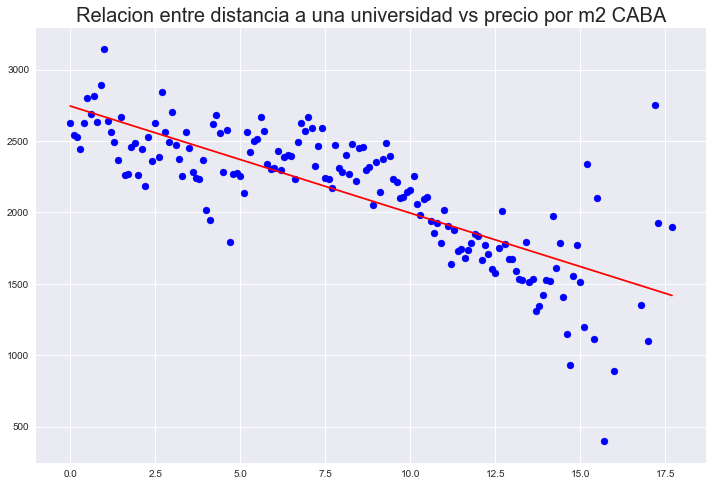

In [91]:
resultados = caba_para_mapa.loc[:,('dist_a_univ','price_usd_per_m2')].groupby('dist_a_univ').mean().reset_index()
titulo = 'Relacion entre distancia a una universidad vs precio por m2 CABA'
plotear_distancias(resultados,'dist_a_univ','price_usd_per_m2',titulo)

## Relacion entre distancia a una villas (o asentamiento) vs precio por m2 CABA

In [92]:
villas = pd.read_csv('datos/datasets/no_CABA/poligonos/informacin-socioeconmica-asentamientos-y-villas-ong-techo.csv')
villas= villas.loc[villas['provincia']=='CABA']
villas['geojson']= [shape(geojson.loads(x)).centroid.xy for x in villas['geojson'].values]
villas['geojson']  = [(y[0],x[0]) for x,y in villas['geojson']]

In [93]:
caba_para_mapa.loc[:,('dist_a_villa')] = [distancia_minima(x,list(villas.loc[:,('geojson')])) for x in caba_para_mapa.loc[:,('lat-lon')]] 

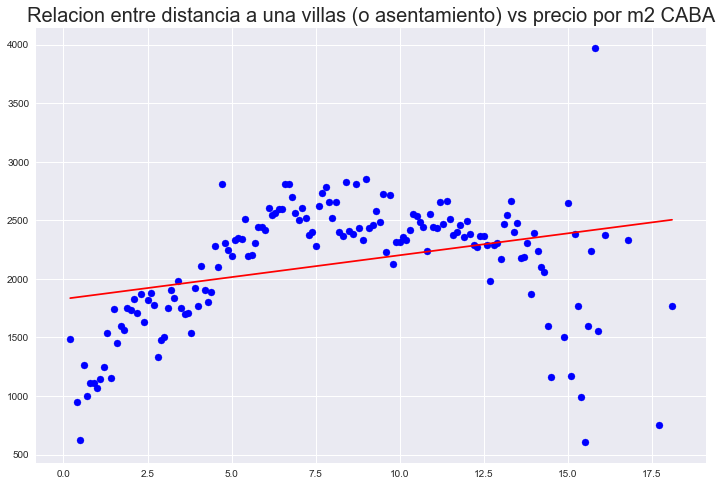

In [94]:
resultados = caba_para_mapa.loc[:,('dist_a_villa','price_usd_per_m2')].groupby('dist_a_villa').mean().reset_index()
titulo = 'Relacion entre distancia a una villas (o asentamiento) vs precio por m2 CABA'
plotear_distancias(resultados,'dist_a_villa','price_usd_per_m2',titulo)

In [95]:
#with open("datos/datasets/CABA/poligonos/sitios-pasibles-de-anegamiento-por-precipitacion-2014.geojson") as json_file:
    #geo_data=geojson.load(json_file)

In [96]:
#lat=[]
#lon=[]
#cluster=[]
#count=0
#for element in geo_data['features']:
   # for coordinate in element['geometry']['coordinates'][0][0]:
        #lat.append(coordinate[0])
        #lon.append(coordinate[1])
        #cluster.append(count)
    #count+=1

In [97]:
#zonas_anegadas=pd.DataFrame({'lat':lat,'lon':lon,'cluster':cluster})
#zonas_anegadas['lat-lon']=[(x, y) for x,y in zip(zonas_anegadas['lat'], zonas_anegadas['lon'])]
   

In [98]:
#gp.polygons(zonas_anegadas['lon'],zonas_anegadas['lat'],zonas_anegadas['cluster'])


In [99]:
caba = properati_filtrado.loc[properati_filtrado.state_name == 'Capital Federal']
caba_para_mapa = caba.dropna(subset= ['lat','lon'])
caba_para_mapa = caba_para_mapa.loc[(caba_para_mapa.lat > -35) & (caba_para_mapa.lat < -34) & (caba_para_mapa.lon > -58.7)]
caba_para_mapa['lat-lon'] = [(y,x) for x,y in zip(caba_para_mapa['lat'], caba_para_mapa['lon'])]


In [100]:
caba_para_mapa['dist_a_zona_anegada'] = [distancia_minima(x, list(zonas_anegadas['lat-lon'])) for x in caba_para_mapa['lat-lon']]


NameError: name 'zonas_anegadas' is not defined

In [ ]:
resultados = caba_para_mapa.loc[:,('dist_a_zona_anegada','price_usd_per_m2')].groupby('dist_a_zona_anegada').mean().reset_index()
plotear_distancias(resultados,'dist_a_zona_anegada','price_usd_per_m2')

# <span style="color:red"> Poner nombre a ejes de graficos y refactorizar. Insertar columnas adicionales como a estrenar, con jardin, con gimnasio en dataframe principal